In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings, inspect
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Application: Drought-Monitor Overview

This notebook put everything together to create a Drought-Monitor application.

* Application website: [Drought-Monitor](makemealink)
* Application code: [Drought-Monitor Source Code](https://github.com/creare-com/podpac-drought-monitor)

# Overview of Activities
* Create **DataSource** nodes to access data sources
* Create **Algorithm** nodes to filter SMAP data
* Create **Compositor** node to combine SMAP data
* Create **Algorithm** node to compute drought categories
* Examine and test completed PODPAC pipeline

# Import Python Modules

In [2]:
# Main PODPAC library
import podpac

# Data source nodes
from podpac.datalib.smap_egi import SMAP
from podpac.datalib.drought_monitor import DroughtMonitorCategory, DroughtCategory

# Algorithm nodes
from podpac.algorithm import YearSubstituteCoordinates, Arithmetic

# Allow insecure evaluation of arbitrary Python code
podpac.settings.set_allow_python_eval_exec(True)

AttributeError: 'PodpacSettings' object has no attribute 'set_allow_python_eval_exec'

# Retrieve Data 
## Computed Drought Categories
* We computed these categories from historical SMAP data and staged the results on AWS S3. 
* To access these datasets, our specific AWS credentials are required.

In [3]:
# S3 Path pointing to zarr data store
source = "s3://podpac-internal-test/drought_parameters.zarr"

In [4]:
# Create the node that points to the .zarr file on S3
d0_source = DroughtMonitorCategory(datakey='d0', source=source)  # This is based on the PODPAC Zarr node

```python
class DroughtMonitorCategory(Zarr):
    dims = ["lat", "lon", "time"]
    cf_time = True
    cf_units = "days since 2018-01-01 00:00:00"
    cf_calendar = "proleptic_gregorian"
```

## Computed Drought Categories: Climatology

In [5]:
# All of our data uses the year '2018', but really describe a climatology. 
# Hence, any incoming coordinates from eval requests should have the year replaced by '2018'
year = '2018'

# This algorithm node take the incoming coordinates, replaces the year by 2018, evaluates the d0_source node, 
# then substitutes the original date in the result
d0 = YearSubstituteCoordinates(year=year, source=d0_source, substitute_eval_coords=True)

In [6]:
# Repeat for the other categories
d1 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d1', source=source), year=year, substitute_eval_coords=True)
d2 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d2', source=source), year=year, substitute_eval_coords=True)
d3 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d3', source=source), year=year, substitute_eval_coords=True)
d4 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d4', source=source), year=year, substitute_eval_coords=True)

## Raw SMAP Soil Moisture Data
* We retrieve this data from S3 using the `Zarr` node. 
* We retrieve Level 3 data (that have AM and PM returns), with quality flags
* We also retrieve Level 4 data (modeled product)

In [7]:
source_L3 = 's3://podpac-internal-test/SPL3SMP_E.002_9km_aid0001.zarr'

kwargs = {
    'dims': ['time', 'lat', 'lon'],
    'latkey': 'fakedim0', 'lonkey': 'fakedim1',
    'cf_time': True, 'cf_calendar': 'proleptic_gregorian', 'cf_units': 'days since 2000-01-01',
    'crs': 'epsg:6933', 'nan_vals': [-9999]
}

In [8]:
smap_e_am_raw = podpac.data.Zarr(source=source_L3, datakey='Soil_Moisture_Retrieval_Data_AM_soil_moisture', **kwargs)
smap_e_pm_raw = podpac.data.Zarr(source=source_L3, datakey='Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm', **kwargs)
smap_e_am_qf = podpac.data.Zarr(source=source_L3, datakey='Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag', **kwargs)
smap_e_pm_qf = podpac.data.Zarr(source=source_L3, datakey='Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm', **kwargs)

# Mask Based on Quality Flag
* For SMAP, if quality flag is 0 or 1, the data can be considered good.
* We use the "Mask" algorithm node to substitute np.nan for any value in the quality flag greater than 1

In [9]:
smap_e_am = podpac.algorithm.Mask(source=smap_e_am_raw, mask=smap_e_am_qf,
                                  bool_op='>', bool_val=1)
smap_e_pm = podpac.algorithm.Mask(source=smap_e_pm_raw, mask=smap_e_pm_qf,
                                  bool_op='>', bool_val=1)

# Add Level 4 Data and Composite
We prefer L3 AM returns, followed by L3 PM returns, and to get full coverage, use the L4 modeled product. 

In [10]:
source_L4 = 's3://podpac-internal-test/SPL4SMGP.004_9km_aid0001.zarr'
smap_L4 = podpac.data.Zarr(source=source_L4, datakey='Geophysical_Data_sm_surface', **kwargs)

smap = podpac.compositor.OrderedCompositor(sources=[smap_e_am,
                                                    smap_e_pm,
                                                    smap_L4
                                                   ], source='SMAP L3 AM/PM Combined')

# Check Compositor Results
Evaluate the node to make sure we're getting something we'd expect.

In [11]:
#Clearing the cache is helpful for debugging in some cases
podpac.utils.clear_cache('ram')

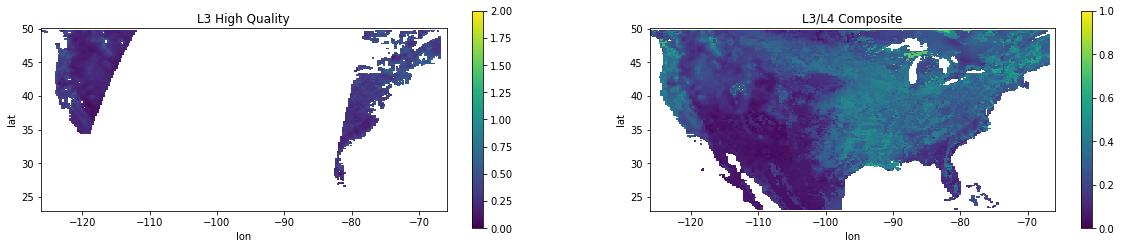

In [12]:
# Make coordinates for checking the intermediate pipeline
coords = podpac.Coordinates([podpac.clinspace(50, 23, 256), podpac.clinspace(-126, -66, 256), '2019-05-19'],
                             ['lat', 'lon', 'time'])

# Evaluate and plot the masked data
o_raw = smap_e_am.eval(coords)
figure(figsize=(20, 4))
subplot(121); o_raw.plot(vmin=0, vmax=2);       axis('scaled'); title('L3 High Quality')

# Evaluate and plot the composited data
o_composite = smap.eval(coords)
subplot(122); o_composite.plot(vmin=0, vmax=1); axis('scaled'); title('L3/L4 Composite')
pass

# Create Algorithm to Convert Raw SMAP Data to Drought Categories
At this point we have access to all of the data sources we need for the main categorization algorithm. 

* We use an Arithmetic node which computes pixel-wise results using an arbitrary equation
* The inputs come from the previously-created nodes, with an A, B, C,... naming convention
   * A-E corresponds to the d0 through d4 categories
   * F is our composited soil moisture

In [13]:
# Create the drought Categorization algorithm
alg = Arithmetic(A=d0, B=d1, C=d2, D=d3, E=d4, F=smap, params={'dn': 0.5, 'd5': 0},
                eqn=('(F >= {d5}) * (F < E) * ((F - {d5}) / (E - {d5}) + 0) + '
                     '(F >= E) * (F < D) * ((F - E) / (D - E) + 1) + '
                     '(F >= D) * (F < C) * ((F - D) / (C - D) + 2) + '
                     '(F >= C) * (F < B) * ((F - C) / (B - C) + 3) + '
                     '(F >= B) * (F < A) * ((F - B) / (A - B) + 4) + '
                     '(F >= A) * (F < {dn}) * ((F - A) / ({dn} - A) + 5) + '
                     '(F >= {dn}) * 5.5'
                    )
                )

In [14]:
# This is also implemented in a custom Algorithm Node, which does the same thing, but more concisely. 
alg = DroughtCategory(d0=d0, d1=d1, d2=d2, d3=d3, d4=d4, soil_moisture=smap)

# Test the PODPAC Algorithm Locally
## Create Coordinates
* The nodes will be evaluated at these coordinates. 
* **Note**: the time series of the categories and the SMAP data do not line up, but PODPAC deals with this automatically using nearest-neighbor interpolation (by default). 

In [15]:
coords = podpac.Coordinates([43, -72,
                             podpac.crange('2019-04-12', '2019-07-10', '3,D')],
                            ['lat', 'lon', 'time'])

## Evaluate the Node Locally

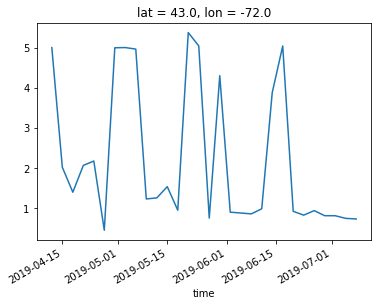

In [17]:
# Most of the execution time comes from retrieving SMAP data 
# The results of this request is cached, so subsequent eval's are fast
o = alg.eval(coords)

# Plot the results
o.plot()
pass

In [18]:
o

<xarray.UnitsDataArray (lat: 1, lon: 1, time: 30)>
array([[[5.009395, 2.019793, 1.395267, 2.064239, 2.174787, 0.444648,
         5.004385, 5.009787, 4.971055, 1.227006, 1.252866, 1.534072,
         0.945038, 5.383892, 5.050078, 0.749056, 4.306948, 0.896968,
         0.875396, 0.853686, 0.98122 , 3.882697, 5.04999 , 0.917755,
         0.822232, 0.935155, 0.80801 , 0.807645, 0.741836, 0.726696]]])
Coordinates:
  * lat      (lat) float64 43.0
  * lon      (lon) float64 -72.0
  * time     (time) datetime64[ns] 2019-04-12 2019-04-15 ... 2019-07-08
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x000001641D235710>
    crs:          EPSG:4326

# Export PODPAC Pipelines for Development of Website
* **Note**, PODPAC kept track of all the nodes used to create the analysis, and recorded this in a light-weight JSON format

In [19]:
def save_json(node, filename):
    with open(filename, 'w') as fid:
        fid.write(node.json_pretty)
        
save_json(d0, 'pipeline_d0.json')
save_json(d1, 'pipeline_d1.json')
save_json(d2, 'pipeline_d2.json')
save_json(d3, 'pipeline_d3.json')
save_json(d4, 'pipeline_d4.json')
save_json(alg, 'pipeline_category.json')
save_json(smap, 'pipeline_moisture.json')

print (alg.json_pretty)

{
    "DroughtMonitorCategory": {
        "node": "datalib.drought_monitor.DroughtMonitorCategory",
        "attrs": {
            "altkey": "alt",
            "crs": null,
            "datakey": "d0",
            "latkey": "lat",
            "lonkey": "lon",
            "timekey": "time"
        },
        "style": {
            "clim": [
                0,
                0.6
            ]
        },
        "source": "s3://podpac-internal-test/drought_parameters.zarr",
        "interpolation": "nearest"
    },
    "YearSubstituteCoordinates": {
        "node": "core.algorithm.coord_select.YearSubstituteCoordinates",
        "attrs": {
            "substitute_eval_coords": true,
            "year": "2018"
        },
        "inputs": {
            "source": "DroughtMonitorCategory"
        }
    },
    "DroughtMonitorCategory_1": {
        "node": "datalib.drought_monitor.DroughtMonitorCategory",
        "attrs": {
            "altkey": "alt",
            "crs": null,
            "da